In [1]:
import torch

N = 10
channels = 3
height = 32
width = 32
D = channels * height * width  # 3072
c = 1

mu = torch.bernoulli(torch.full((N, D), 0.5)) * c
print(mu.shape)

torch.save(mu, f"prior_mean_bernoulli_seperateCH_{D}dim_{N}point_constant{c}.pt")

def pairwise_distance_stats(pts: torch.Tensor):
    dist_mat = torch.cdist(pts, pts, p=2)  # (N, N)
    N = pts.shape[0]

    mask = torch.triu(torch.ones(N, N), diagonal=1).bool()
    pairwise_dists = dist_mat[mask]  # (N*(N-1)/2,)

    mean_pairwise_dist = pairwise_dists.mean()
    std_pairwise_dist = pairwise_dists.std()
    min_pairwise_dist = pairwise_dists.min()
    max_pairwise_dist = pairwise_dists.max()

    tdm_pairwise = torch.sum(torch.abs(pairwise_dists - mean_pairwise_dist))

    norms = torch.norm(pts, dim=1, p=2)
    mean_norm = norms.mean()
    std_norm = norms.std()
    min_norm = norms.min()
    max_norm = norms.max()

    tdm_norms = torch.sum(torch.abs(norms - mean_norm))

    return (pairwise_dists, mean_pairwise_dist, std_pairwise_dist, min_pairwise_dist, max_pairwise_dist, tdm_pairwise,
            norms, mean_norm, std_norm, min_norm, max_norm, tdm_norms)

(pairwise_dists, mean_pd, std_pd, min_pd, max_pd, tdm_pd,
 norms, mean_n, std_n, min_n, max_n, tdm_n) = pairwise_distance_stats(mu)

print(f"== {N}-point simplex in {D}-dim (Bernoulli embedding) ==")
print("Pairwise distances:", pairwise_dists)
print(f"Mean = {mean_pd:.6f}, Std = {std_pd:.6f}, Min = {min_pd:.6f}, Max = {max_pd:.6f}")
print(f"Total deviation from mean (pairwise) = {tdm_pd:.6f}")

print("\nDistance from origin:", norms)
print(f"Mean norm = {mean_n:.6f}, Std = {std_n:.6f}, Min = {min_n:.6f}, Max = {max_n:.6f}")
print(f"Total deviation from mean (norms) = {tdm_n:.6f}")


torch.Size([10, 3072])
== 10-point simplex in 3072-dim (Bernoulli embedding) ==
Pairwise distances: tensor([38.3406, 39.6863, 39.2938, 39.3573, 39.3954, 38.6782, 38.5357, 39.1791,
        38.8587, 38.8458, 39.2938, 39.6106, 39.1918, 39.4462, 39.0512, 39.3573,
        39.9500, 39.2556, 39.3700, 39.2810, 39.2301, 39.7240, 38.8072, 38.7427,
        39.5348, 38.6782, 39.1663, 39.8873, 39.4842, 38.9102, 39.2046, 38.8458,
        38.6782, 39.4208, 39.0768, 39.2683, 38.7685, 39.3319, 39.1152, 38.8716,
        39.5095, 38.9102, 39.3446, 39.6611, 39.8372])
Mean = 39.199730, Std = 0.374001, Min = 38.340580, Max = 39.949970
Total deviation from mean (pairwise) = 13.484989

Distance from origin: tensor([38.9230, 38.9743, 39.7240, 39.2556, 38.6523, 38.8716, 39.3827, 39.4462,
        39.0384, 38.8201])
Mean norm = 39.108833, Std = 0.332414, Min = 38.652298, Max = 39.724049
Total deviation from mean (norms) = 2.746422


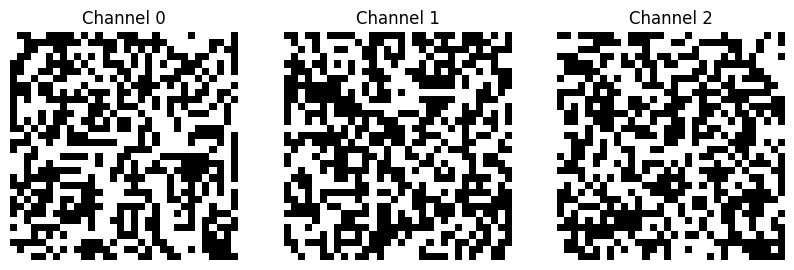

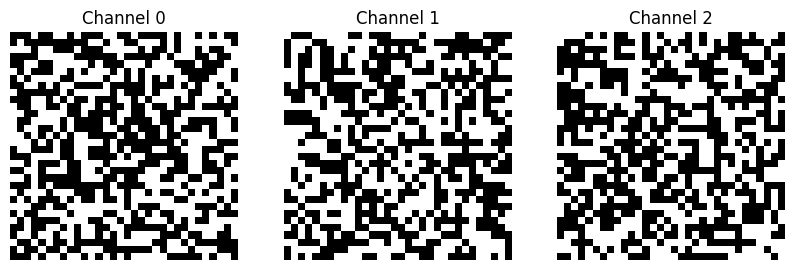

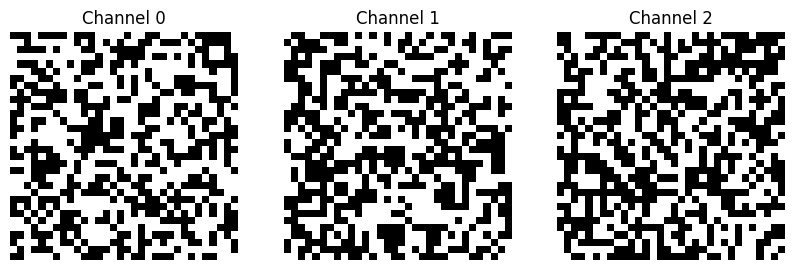

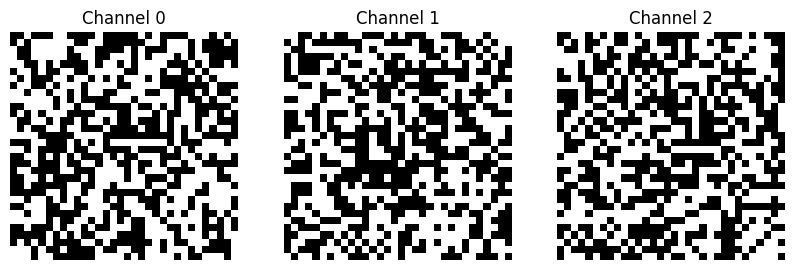

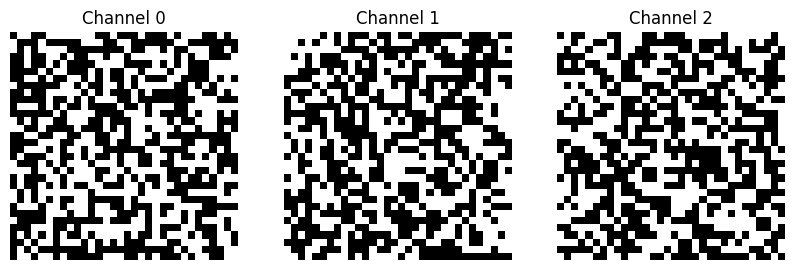

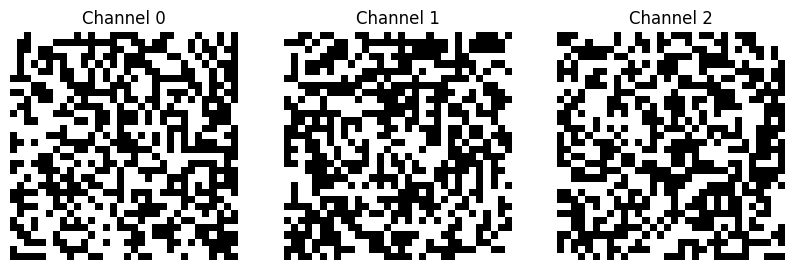

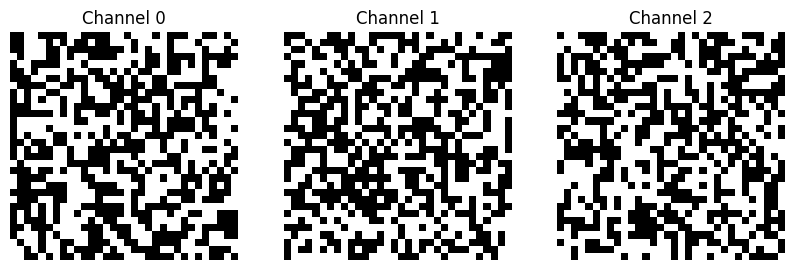

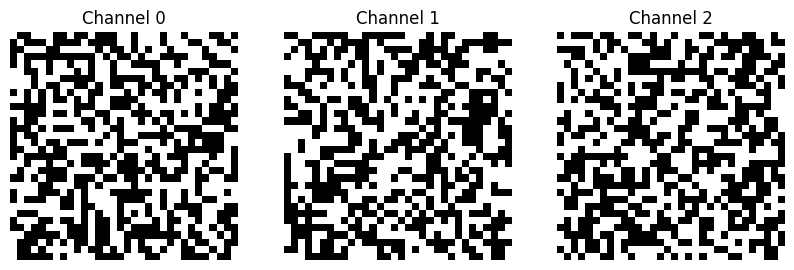

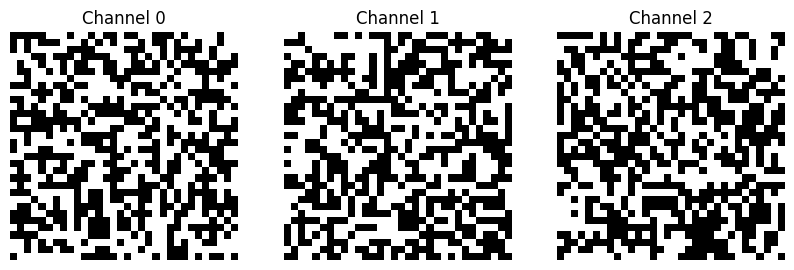

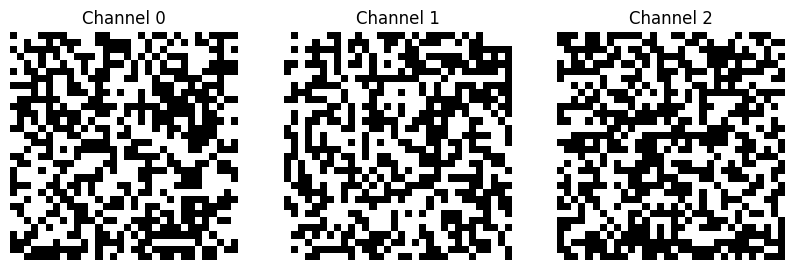

In [2]:
import matplotlib.pyplot as plt

mu_reshaped = mu.view(N, channels, height, width)

for i in range(N):
    fig, axs = plt.subplots(1, channels, figsize=(10, 3))
    for ch in range(channels):
        axs[ch].imshow(mu_reshaped[i, ch].cpu().numpy(), cmap="gray")
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].axis("off")
    plt.show()


In [5]:
import torch

# 이미지 크기 및 채널 수 정의
height = 32
width = 32
channels = 3
N = 10
D = channels * height * width  # 최종 차원: 3072
c = 1

# (N, 32, 32) 크기의 텐서를 베르누이 분포(각 원소 0 또는 1, 확률 0.5)로 샘플링
sampled_pixels = torch.bernoulli(torch.full((N, height, width), 0.5)) * c

# 각 픽셀의 값을 3채널에 동일하게 복제하여 (N, 3, 32, 32) 형태로 확장
mu = sampled_pixels.unsqueeze(1).repeat(1, channels, 1, 1)

# 이후 분석을 위해 (N, 3072) 크기로 평탄화
mu = mu.view(N, D)
print(mu.shape)

torch.save(mu, f"prior_mean_bernoulli_sharedCH_{D}dim_{N}point_constant{c}.pt")

def pairwise_distance_stats(pts: torch.Tensor):
    """
    모든 점 쌍 거리 및 각 점의 원점까지 거리(노름) 통계량을 반환하며,
    평균(mean), 표준편차(std), 최소(min), 최대(max) 및 평균으로부터의 총 편차(TDM)도 계산.
    """
    dist_mat = torch.cdist(pts, pts, p=2)  # (N, N)
    N = pts.shape[0]

    # 상삼각(또는 하삼각) 마스크
    mask = torch.triu(torch.ones(N, N), diagonal=1).bool()
    pairwise_dists = dist_mat[mask]  # (N*(N-1)/2,)

    # 평균, 표준편차, 최소, 최대
    mean_pairwise_dist = pairwise_dists.mean()
    std_pairwise_dist = pairwise_dists.std()
    min_pairwise_dist = pairwise_dists.min()
    max_pairwise_dist = pairwise_dists.max()

    # 평균으로부터의 총 편차 (Total Deviation from Mean, TDM)
    tdm_pairwise = torch.sum(torch.abs(pairwise_dists - mean_pairwise_dist))

    # 각 점의 원점까지 거리 (노름)
    norms = torch.norm(pts, dim=1, p=2)
    mean_norm = norms.mean()
    std_norm = norms.std()
    min_norm = norms.min()
    max_norm = norms.max()

    # 평균으로부터의 총 편차 (TDM) for norms
    tdm_norms = torch.sum(torch.abs(norms - mean_norm))

    return (pairwise_dists, mean_pairwise_dist, std_pairwise_dist, min_pairwise_dist, max_pairwise_dist, tdm_pairwise,
            norms, mean_norm, std_norm, min_norm, max_norm, tdm_norms)

# (4) 통계 확인
(pairwise_dists, mean_pd, std_pd, min_pd, max_pd, tdm_pd,
 norms, mean_n, std_n, min_n, max_n, tdm_n) = pairwise_distance_stats(mu)

print(f"== {N}-point simplex in {D}-dim (Bernoulli embedding) ==")
print("Pairwise distances:", pairwise_dists)
print(f"Mean = {mean_pd:.6f}, Std = {std_pd:.6f}, Min = {min_pd:.6f}, Max = {max_pd:.6f}")
print(f"Total deviation from mean (pairwise) = {tdm_pd:.6f}")

print("\nDistance from origin:", norms)
print(f"Mean norm = {mean_n:.6f}, Std = {std_n:.6f}, Min = {min_n:.6f}, Max = {max_n:.6f}")
print(f"Total deviation from mean (norms) = {tdm_n:.6f}")


torch.Size([10, 3072])
== 10-point simplex in 3072-dim (Bernoulli embedding) ==
Pairwise distances: tensor([39.0768, 39.2683, 39.6863, 38.5746, 39.8748, 39.2301, 39.0768, 39.3446,
        38.8458, 39.6863, 38.0263, 38.1445, 38.1445, 39.3446, 39.7995, 39.3827,
        39.4208, 39.2301, 39.4208, 38.9615, 39.7618, 38.8458, 39.5727, 40.2865,
        38.6135, 39.9124, 39.3446, 40.0250, 39.0768, 39.2683, 38.1838, 38.6135,
        38.3797, 38.8072, 39.1535, 38.9230, 39.0000, 39.1918, 38.8458, 39.1918,
        38.9230, 38.3406, 39.2301, 39.1152, 39.0000])
Mean = 39.114361, Std = 0.522050, Min = 38.026306, Max = 40.286472
Total deviation from mean (pairwise) = 17.996078

Distance from origin: tensor([38.3797, 39.1918, 39.3065, 40.2492, 39.5348, 40.0625, 39.8748, 39.0384,
        39.5348, 38.0263])
Mean norm = 39.319881, Std = 0.704627, Min = 38.026306, Max = 40.249222
Total deviation from mean (norms) = 5.313313


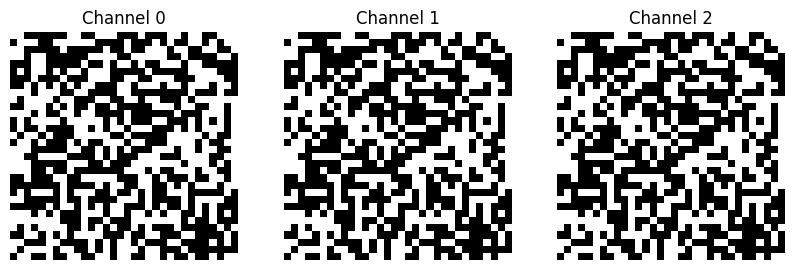

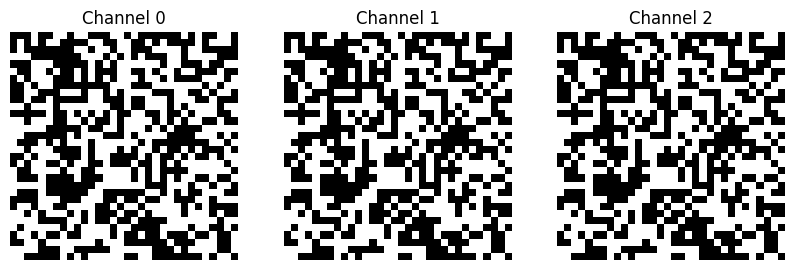

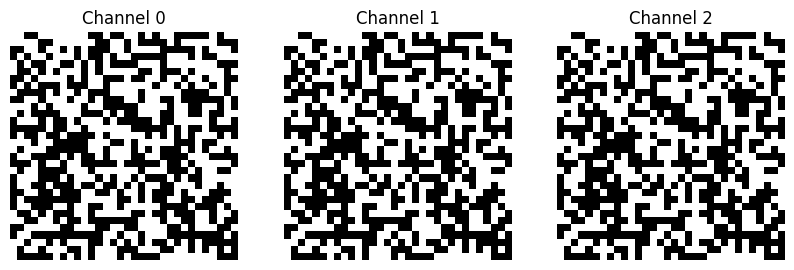

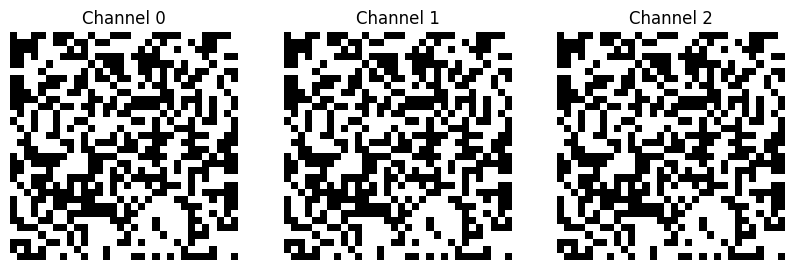

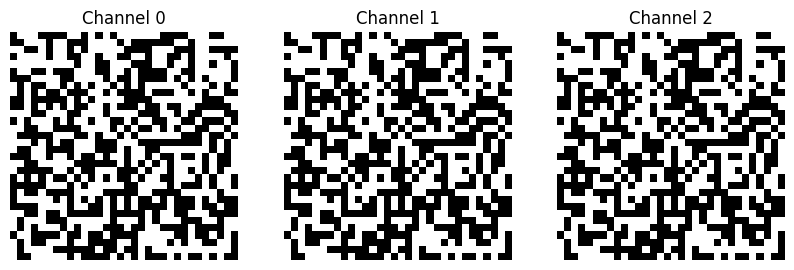

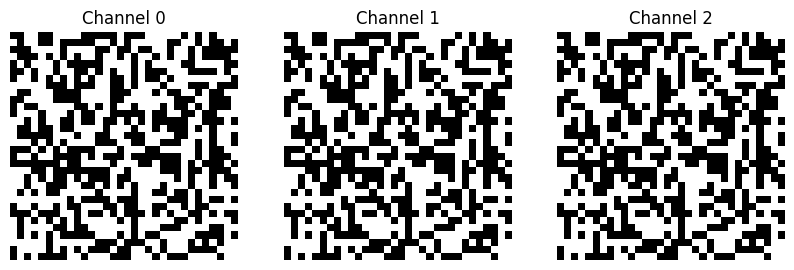

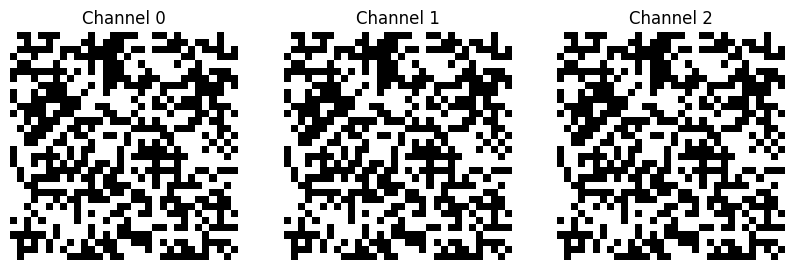

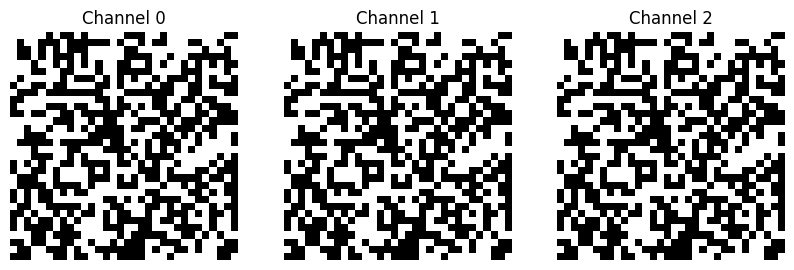

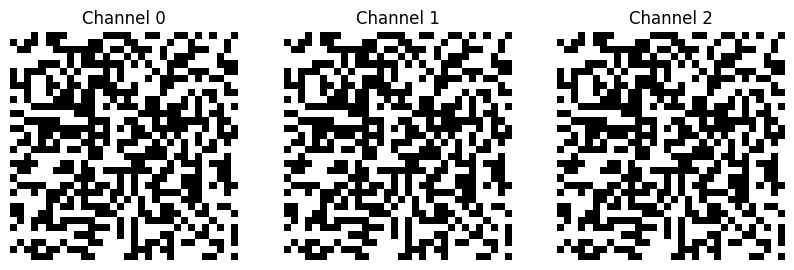

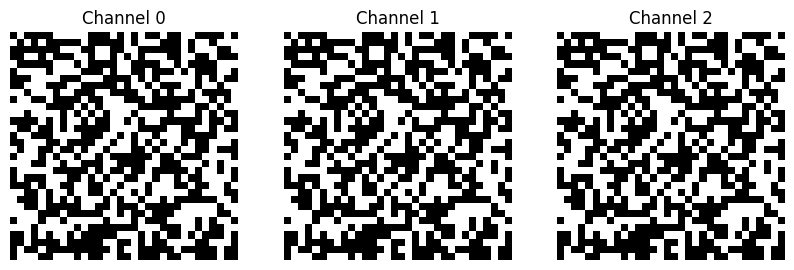

In [ ]:
import matplotlib.pyplot as plt

mu_reshaped = mu.view(N, channels, height, width)

for i in range(N):
    fig, axs = plt.subplots(1, channels, figsize=(10, 3))
    for ch in range(channels):
        axs[ch].imshow(mu_reshaped[i, ch].cpu().numpy(), cmap="gray")
        axs[ch].set_title(f"Channel {ch}")
        axs[ch].axis("off")
    plt.show()
